In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
plt.style.use('seaborn-v0_8-whitegrid')

Start off by just investigating the data a bit. At < 0.25 GB this is manageable in a notebook

In [25]:
data_file = 'trawlers.parquet'
df = pd.read_parquet(data_file)
df.head()

,mmsi,ts_pos_utc,speed,course,latitude,longitude,fishing,vessel_class
0,1252339803566,2015-01-01 05:08:23,0.0,128.0,52.458717,4.581316,0.0,trawlers
1,1252339803566,2015-01-01 05:20:34,0.0,128.0,52.458733,4.581316,0.0,trawlers
2,1252339803566,2015-01-01 05:32:53,0.0,128.0,52.458698,4.581267,0.0,trawlers
3,1252339803566,2015-01-01 05:45:23,0.0,128.0,52.458698,4.581234,0.0,trawlers
4,1252339803566,2015-01-01 05:57:24,0.0,128.0,52.458683,4.581183,0.0,trawlers


In [26]:
df.dtypes

mmsi              int64
ts_pos_utc       object
speed           float64
course          float64
latitude        float64
longitude       float64
fishing         float64
vessel_class     object
dtype: object

The timestamp isn't being read in as a datetime object, so we'll handle that conversion first

In [27]:
df["ts_pos_utc"] = pd.to_datetime(df["ts_pos_utc"])

In [28]:
df.describe()

,mmsi,ts_pos_utc,speed,course,latitude,longitude,fishing
count,1.579520e+05,157952,157950.000000,157950.000000,157952.000000,157952.000000,157952.000000
mean,2.026783e+14,2014-12-24 07:22:23.726872832,3.152446,179.818974,43.710635,-3.039028,0.388574
min,1.252340e+12,2012-01-01 09:21:55,0.000000,0.000000,-50.192177,-179.691055,0.000000
25%,1.696186e+14,2014-10-15 02:35:49.750000128,0.000000,74.300003,42.169393,-13.990942,0.000000
50%,2.311543e+14,2015-02-16 14:23:01.500000,2.400000,196.699997,53.865986,5.696722,0.000000
75%,2.690503e+14,2015-08-13 14:12:14,4.400000,276.700012,68.160473,16.547539,1.000000
max,2.775153e+14,2016-04-15 05:22:41,102.300003,360.000000,78.925163,179.699615,1.000000
std,8.217513e+13,NaN,3.885416,112.563052,34.482788,44.413152,0.487428


In [29]:
df['fishing'].value_counts(dropna=False)

fishing
0.0    96576
1.0    61376
Name: count, dtype: int64

In [30]:
df['vessel_class'].value_counts(dropna=False)

vessel_class
trawlers    157952
Name: count, dtype: int64

The course (compass heading), latitude, and longitude all seem to make sense within what their bounds should be - 0 to 360 degrees for heading, -90 to +90 for latitude (realistically less considering the poles), and -180 to +180 for longitude. Additionally the 'fishing' label looks to just be binary, so that's good.

For columns that we won't be too worried about: the 'vessel_class' seems to be an unimportant feature for this dataset (everything is just a trawler). It's worth noting that this would probably be worth keeping in a dataset with various vessel types, as one-hot encoded variables. Additionally the MMSI will not be included in the modeling. Although we're treating it as an integer, it's simply the identifier for a vessel, meaning it is more akin to a string. Lastly, although the timestamp is useful in aggregating data (discussed later) I will not be using it as a direct input into the model. The local time for each vessel would most likely be more relevant that the UTC time, and even then a time-series analysis would be a very fundamentally different analysis.

One other great point to take note of is that the binary 'fishing' variable, which is the one we will be modeling, has decent balance. There is more non-fishing data points, but with a ~60/40 split we won't have to implement any oversampling techniques when modeling.

Next I'll check for missing data

In [31]:
df[df.isnull().any(axis=1)]

,mmsi,ts_pos_utc,speed,course,latitude,longitude,fishing,vessel_class
395081,274850145767759,2015-05-05 13:41:32,NaN,NaN,-43.842186,-86.200233,1.0,trawlers
395091,274850145767759,2015-05-06 06:21:49,NaN,NaN,-43.146439,-86.096268,0.0,trawlers


In [32]:
df[df["mmsi"] == 274850145767759].describe()

,mmsi,ts_pos_utc,speed,course,latitude,longitude,fishing
count,1.485500e+04,14855,14853.000000,14853.000000,14855.000000,14855.000000,14855.000000
mean,2.748501e+14,2014-04-05 06:55:06.843217920,5.797644,183.494944,-33.478207,-80.148623,0.471828
min,2.748501e+14,2012-01-01 09:21:55,0.000000,0.000000,-47.113712,-93.294449,0.000000
25%,2.748501e+14,2013-06-06 22:02:15.500000,3.200000,90.000000,-41.949118,-82.297951,0.000000
50%,2.748501e+14,2014-06-26 18:08:25,5.600000,189.100006,-39.019215,-79.520569,0.000000
75%,2.748501e+14,2015-04-30 18:03:01,9.000000,274.600006,-33.639210,-78.387688,1.000000
max,2.748501e+14,2015-11-01 01:36:08,14.600000,359.899994,8.954407,-73.024734,1.000000
std,0.000000e+00,NaN,3.774819,105.055209,15.378322,4.006674,0.499222


Only 2 rows have any data missing, that's really nice. Considering it is only for 1 specific vessel, and that vessel has ~15,000 other data points it should be safe to toss that data. If there were more missing values across multiple vessels I would consider replacing the missing values with the most recent values for each individual vessel, but that makes the assumption that there would not be a large time gap between the two values.

In [33]:
df.dropna(inplace=True)
df.drop(columns="vessel_class", inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

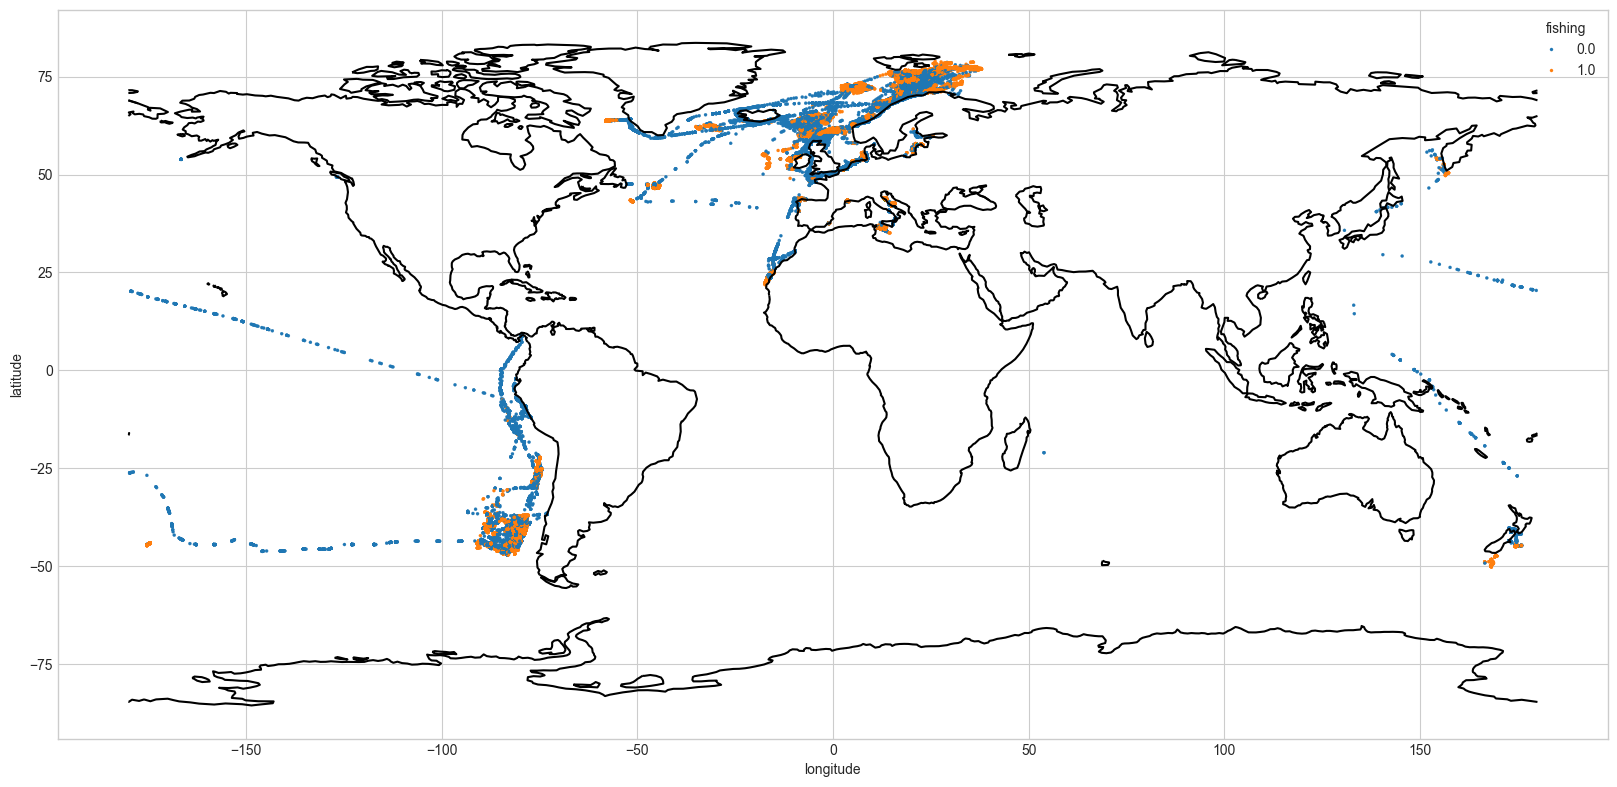

In [101]:
world = gpd.read_file('./ne_110m_coastline.zip')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

world.plot(ax=ax,color="black")
sns.scatterplot(data=df,x='longitude',y='latitude',hue='fishing', s=5, edgecolor=None, ax=ax)

It looks like there are some places that are more obvious fishing zones than others, so lat/lon will be very good useful features. On a smaller scale we could consider creating bins that represent large areas of the ocean and encode the location as a one-hot variable, but on a global scale that would likely require 100s of bins, which would strain the amount of data we have (less than a million)

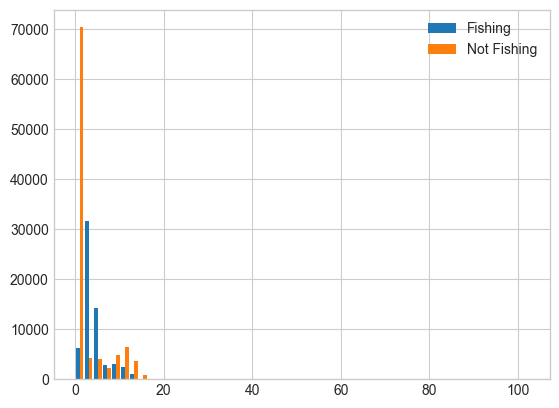

In [72]:
counts, bins, _ = plt.hist([df[df["fishing"] == 1]['speed'],df[df["fishing"] == 0]['speed']], bins=50, color=["C0","C1"])
plt.legend({"Fishing":"C0","Not Fishing":"C1"})

We can use the world map from earlier to calculate how far each point is from the nearest shore. This isn't a perfect way to estimate this, as the nearest shoreline could be Antarctica, which isn't a shoreline we would normally care about for fishing boats (if we assume proximity to a port matters). Because this calculation uses lat/lon coordinates the resulting distance will be in degrees separation. Rather than using a multiplicative factor to get this into linear distance I will leave it in degrees, as I plan to use a transformer later to scale all of the variables for the modeling. In this sense it doesn't matter, as angles ranging from 0 to 30 degrees will get scaled down all the same as distances ranging from 0 to 3,500 km.

In [143]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")
gdf["shore_dist"] = gdf["geometry"].apply(lambda x: min(x.distance(coastline) for coastline in world["geometry"]))


I'll do a quick visualization to make sure this was calculated properly (the colors appear to be consistent)

<Axes: xlabel='longitude', ylabel='latitude'>

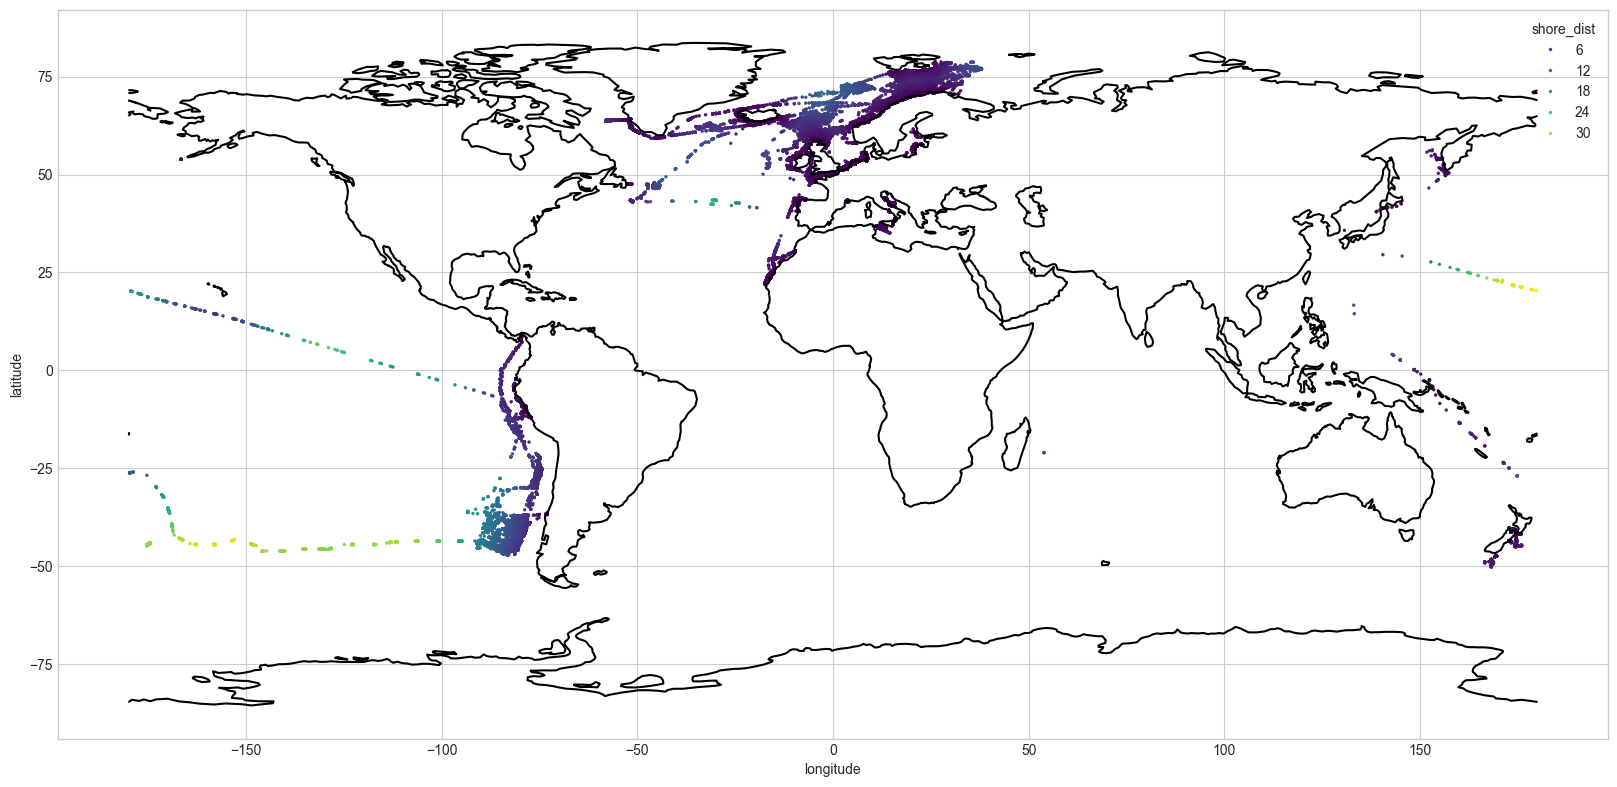

In [150]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

world.plot(ax=ax,color="black")
sns.scatterplot(data=gdf,x='longitude',y='latitude',hue='shore_dist', s=5, palette='viridis', edgecolor=None, ax=ax)

Lastly, we'll probably want to take a look at some aggregated data. Because these ships span the world's oceans it wouldn't make sense to aggregate all data within a certain time window. Instead we'll need to group by MMSI, then aggregate over a given time window.

In [188]:
def change_in_speed(x):
    return x.max() - x.min()

df_deltav = []
for mmsi, df_group in gdf[["mmsi","ts_pos_utc","speed"]].groupby("mmsi"):
    df_resampled = df_group.resample("1h", on="ts_pos_utc").apply(change_in_speed).dropna(axis=0)
    df_resampled['mmsi'] = mmsi
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={"speed":"change_in_speed","ts_pos_utc":"rounded_hours"}, inplace=True)
    df_deltav.append(df_resampled)

df_deltav = pd.concat(df_deltav, ignore_index=True)
    

In [182]:
gdf["merging_hour"] = gdf["ts_pos_utc"].dt.floor('H')
gdf = gdf.merge(df_deltav, left_on=["mmsi","merging_hour"], right_on=["mmsi","rounded_hours"])